In [2]:
%matplotlib inline

In [4]:
import json

from elasticsearch_dsl import F, A, Q

from sharepa import ShareSearch, basic_search, bucket_to_dataframe, merge_dataframes

# This is just a helper function for pretty printing dictionaries
def pretty_print(d):
    print json.dumps(d, indent=4)

# We include a basic search, that gets all the documents and a simple aggregation by source
basic_search.count()

2137806

In [5]:
# <search>.execute sends the actual query to the SHARE API
results = basic_search.execute()

In [6]:
# Iterating through the results is easy!
for hit in results:
    print hit.title

Avian community structure and incidence of human West Nile infection
Rat12_a
Non compact continuum limit of two coupled Potts models

Simultaneous Localization, Mapping, and Manipulation for Unsupervised
  Object Discovery
Synthesis of High-Temperature Self-lubricating Wear Resistant Composite Coating on Ti6Al4V Alloy by Laser Deposition
Comparative Studies of Silicon Dissolution in Molten Aluminum Under Different Flow Conditions, Part I: Single-Phase Flow
Scrambling of data in all-optical domain
Non-Gaussian bias: insights from discrete density peaks
Step behaviour and autonomic nervous system activity in multiparous dairy cows during milking in a herringbone milking system


In [7]:
# If we don't want 10 results, or we want to offset the results, we can use slices
results = basic_search[5:10].execute()
for hit in results:
    print hit.title

Synthesis of High-Temperature Self-lubricating Wear Resistant Composite Coating on Ti6Al4V Alloy by Laser Deposition
Comparative Studies of Silicon Dissolution in Molten Aluminum Under Different Flow Conditions, Part I: Single-Phase Flow
Scrambling of data in all-optical domain
Non-Gaussian bias: insights from discrete density peaks
Step behaviour and autonomic nervous system activity in multiparous dairy cows during milking in a herringbone milking system


In [9]:
# Plotting is also not hard, you just need to pass a bucket to this function!
my_data_frame = bucket_to_dataframe('# documents by source', results.aggregations.sourceAgg.buckets)
my_data_frame.plot(kind='bar')

KeyError: 'doc_count'

In [10]:
# Of course, you can make your own search object as well
my_search = ShareSearch()

# And adding queries to it is pretty simple!
my_search = my_search.query(
    'query_string', # This query will accept a lucene query string
    query='NOT tags:*', # This lucene query string will find all documents that don't have tags
    analyze_wildcard=True  # This will make elasticsearch pay attention to the asterisk (which matches anything)
)

In [11]:
# Aggregations, which are useful for data analysis, follow a similar pattern
my_search.aggs.bucket(
    'sources',  # Every aggregation needs a name
    'terms',  # There are many kinds of aggregations, terms is a pretty useful one though
    field='_type',  # We store the source of a document in its type, so this will aggregate by source
    size=0,  # These are just to make sure we get numbers for all the sources, to make it easier to combine graphs
    min_doc_count=0
)

# We can see what query is actually going to be sent to elasticsearch
pretty_print(my_search.to_dict())

{
    "query": {
        "query_string": {
            "analyze_wildcard": true, 
            "query": "NOT tags:*"
        }
    }, 
    "aggs": {
        "sources": {
            "terms": {
                "field": "_type", 
                "min_doc_count": 0, 
                "size": 0
            }
        }
    }
}


In [12]:
# Let's make a more interesting aggregation. Let's look at the documents that are missing titles, by source
my_search.aggs.bucket(
    'hasTitle',  # so here we will see how many documents will be missing titles
    'filters', # We'll want to filter all the documents that have titles
    filters={ 
        'hasTitle': F(  # F defines a filter
            'fquery',  # This is a query filter which takes a query and filters document by it
            query=Q(  # Q can define a query
                'query_string', 
                query='title:*',  # This will match all documents that don't have content in the title field
                analyze_wildcard=True,
            )
        ) 
    }
)
my_search.aggs.bucket(
    'hasDescription',  # so here we will see how many documents will be missing titles
    'filters', # We'll want to filter all the documents that have titles
    filters={ 
        'hasDescription': F(  # F defines a filter
            'fquery',  # This is a query filter which takes a query and filters document by it
            query=Q(  # Q can define a query
                'query_string', 
                query='description:*',  # This will match all documents that don't have content in the title field
                analyze_wildcard=True,
            )
        ) 
    }
)
my_search.aggs.bucket(
    'hasTags',  # so here we will see how many documents will be missing titles
    'filters', # We'll want to filter all the documents that have titles
    filters={ 
        'hasTags': F(  # F defines a filter
            'fquery',  # This is a query filter which takes a query and filters document by it
            query=Q(  # Q can define a query
                'query_string', 
                query='tags:* OR subjects:*',  # This will match all documents that don't have content in the title field
                analyze_wildcard=True,
            )
        ) 
    }
)
pretty_print(my_search.to_dict()) # Wow this query has gotten big! Good thing we don't have to define it by hand

{
    "query": {
        "query_string": {
            "analyze_wildcard": true, 
            "query": "NOT tags:*"
        }
    }, 
    "aggs": {
        "hasDescription": {
            "filters": {
                "filters": {
                    "hasDescription": {
                        "fquery": {
                            "query": {
                                "query_string": {
                                    "query": "description:*", 
                                    "analyze_wildcard": true
                                }
                            }
                        }
                    }
                }
            }
        }, 
        "sources": {
            "terms": {
                "field": "_type", 
                "min_doc_count": 0, 
                "size": 0
            }
        }, 
        "hasTitle": {
            "filters": {
                "filters": {
                    "hasTitle": {
                        "fquery": {
           

In [13]:
# just need to execute the search
my_results = my_search.execute()
my_results.aggregations.to_dict()

{u'hasDescription': {u'buckets': {u'hasDescription': {u'doc_count': 1071105}}},
 u'hasTags': {u'buckets': {u'hasTags': {u'doc_count': 762800}}},
 u'hasTitle': {u'buckets': {u'hasTitle': {u'doc_count': 1765935}}},
 u'sources': {u'buckets': [{u'doc_count': 377931, u'key': u'datacite'},
   {u'doc_count': 353755, u'key': u'crossref'},
   {u'doc_count': 260685, u'key': u'dataone'},
   {u'doc_count': 244988, u'key': u'arxiv_oai'},
   {u'doc_count': 209828, u'key': u'figshare'},
   {u'doc_count': 208081, u'key': u'pubmedcentral'},
   {u'doc_count': 94362, u'key': u'scitech'},
   {u'doc_count': 53188, u'key': u'mit'},
   {u'doc_count': 32271, u'key': u'plos'},
   {u'doc_count': 27523, u'key': u'iowaresearch'},
   {u'doc_count': 24145, u'key': u'bhl'},
   {u'doc_count': 18339, u'key': u'biomedcentral'},
   {u'doc_count': 14086, u'key': u'clinicaltrials'},
   {u'doc_count': 12715, u'key': u'zenodo'},
   {u'doc_count': 12352, u'key': u'asu'},
   {u'doc_count': 11108, u'key': u'scholarsbank'},
   

In [16]:
# let's look at those hits!
for hit in my_results:
    print hit.title, hit.get('tags')  # we can see there are no tags in our results

Avian community structure and incidence of human West Nile infection []
Non compact continuum limit of two coupled Potts models None
 []
Simultaneous Localization, Mapping, and Manipulation for Unsupervised
  Object Discovery None
Synthesis of High-Temperature Self-lubricating Wear Resistant Composite Coating on Ti6Al4V Alloy by Laser Deposition None
Comparative Studies of Silicon Dissolution in Molten Aluminum Under Different Flow Conditions, Part I: Single-Phase Flow None
Scrambling of data in all-optical domain None
Non-Gaussian bias: insights from discrete density peaks None
Step behaviour and autonomic nervous system activity in multiparous dairy cows during milking in a herringbone milking system None
<p>Typical features of the constant velocity forced dissociation process in the SGP-3-ligated 1G1Q 2CR complex system.</p> None


In [17]:
# Let's pull out those buckets and turn them into dataframes
missing_title = bucket_to_dataframe('missingTitle', my_results.aggregations.missingTitle.buckets.missingTitle.sourceAgg.buckets)
matches = bucket_to_dataframe('matches', my_results.aggregations.sources.buckets)

AttributeError: 'AttrDict' object has no attribute 'missingTitle'

In [18]:
# It will be more useful to analyze these dataframes together
# Luckily, we have a handy function for merging dataframes (as long as they have the same indices)
merged = merge_dataframes(source_counts(), matches,  missing_title)
merged

NameError: name 'source_counts' is not defined

In [19]:
merged.plot(kind='bar')

NameError: name 'merged' is not defined

In [20]:
# We can also easily do computations on these columns, and add those to the dataframe
merged['percent_missing_tags_and_title'] = (merged.missingTitle / merged.total_source_counts) * 100
merged

NameError: name 'merged' is not defined

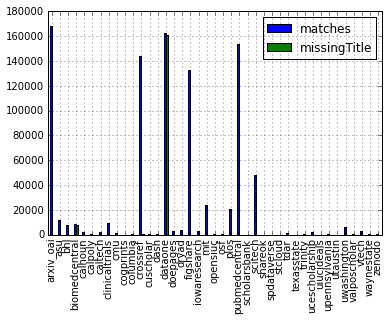

In [16]:
# Now we are getting a lot of columns though
# If we only want to plot some of the columns, we can do this:
merged.loc[:, ['matches', 'missingTitle']].plot(kind='bar')

In [95]:
# Let's just go through a few more examples
date_hist_search = ShareSearch()
date_hist_search.aggs.bucket(
    'dates', 
    A(
        'date_histogram', 
        field='providerUpdatedDateTime', 
        interval='1d', 
        format='yyyy-MM-dd'
    )
)# .metric('sources', 'terms', field='_type', size=0, min_doc_count=0)

DateHistogram(field='providerUpdatedDateTime', format='yyyy-MM-dd', interval='1d')

In [96]:
res = date_hist_search.execute()

In [97]:
buckets = res.aggregations.dates.buckets

def buckets_date_switch(bucket):
    from dateutil import parser
    bucket.key = parser.parse(bucket.key_as_string)
    return bucket

data = map(buckets_date_switch, buckets)

In [98]:
df = bucket_to_dataframe('count', data)

In [99]:
import pandas as pd

new_df = pd.DataFrame(columns=['dates'])

In [100]:
freqs = pd.DataFrame(columns=['date', 'count'])

count = 0
for x, y in zip(df.index, df['count']):
    freqs.loc[count] = (x, y)
    count += 1

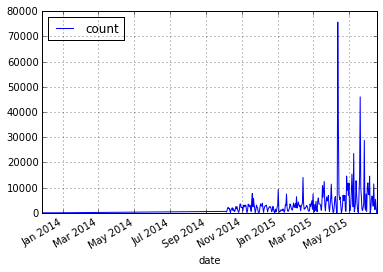

In [101]:
freqs.plot(x='date', y='count')

In [106]:
date_source_search = ShareSearch()
date_source_search.aggs.bucket(
    'dates', 
    A(
        'date_histogram', 
        field='providerUpdatedDateTime', 
        interval='1d', 
        format='yyyy-MM-dd'
    )
).metric('sources', 'terms', field='_type', size=0, min_doc_count=0)

date_sources = date_source_search.execute()

In [107]:
dfs = []
for bucket in date_sources.aggregations.dates.buckets:
    dfs.append(bucket_to_dataframe(bucket.key_as_string, bucket.sources.buckets))

In [108]:
merged = merge_dataframes(*dfs)

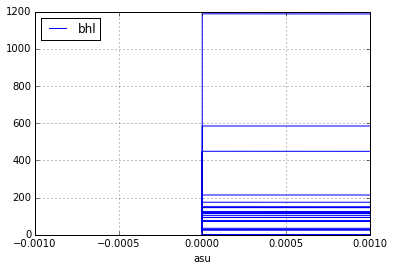

In [147]:
merged.T.plot(x='asu', y='bhl')

In [123]:
import matplotlib.pyplot as plt
merged.T.index

Index([u'2013-11-26', u'2013-11-27', u'2013-12-18', u'2014-10-03',
       u'2014-10-04', u'2014-10-05', u'2014-10-06', u'2014-10-07',
       u'2014-10-08', u'2014-10-09', 
       ...
       u'2015-06-08', u'2015-06-09', u'2015-06-10', u'2015-06-11',
       u'2015-06-12', u'2015-06-13', u'2015-06-14', u'2015-06-15',
       u'2015-06-16', u'2015-06-17'],
      dtype='object', length=261)

In [132]:
from dateutil import parser
x = merged.T
x.index = pd.DatetimeIndex(map(parser.parse, merged.T.index))

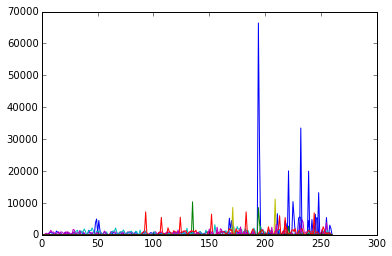

In [137]:
plt.plot(x)

In [142]:
s = ShareSearch()
s.aggs.bucket(
    'missingTitle',  # so here we will see how many documents will be missing titles
    'filters', # We'll want to filter all the documents that have titles
    filters={ 
        'missingTitle': F(  # F defines a filter
            'fquery',  # This is a query filter which takes a query and filters document by it
            query=Q(  # Q can define a query
                'query_string', 
                query='NOT title:*',  # This will match all documents that don't have content in the title field
                analyze_wildcard=True,
            )
        ) 
    }
).metric('sources', source_agg)
pretty_print(s.execute().aggregations.to_dict())

{
    "missingTitle": {
        "buckets": {
            "missingTitle": {
                "sources": {
                    "buckets": [
                        {
                            "key": "dataone", 
                            "doc_count": 166302
                        }, 
                        {
                            "key": "biomedcentral", 
                            "doc_count": 8608
                        }, 
                        {
                            "key": "crossref", 
                            "doc_count": 889
                        }, 
                        {
                            "key": "pubmedcentral", 
                            "doc_count": 22
                        }, 
                        {
                            "key": "caltech", 
                            "doc_count": 3
                        }, 
                        {
                            "key": "scitech", 
                            "doc_count": 3
   